### Import libraries

In [1]:
import warnings

import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
import sys
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["USE_OPENMP"] = '1'

sys.path.append(os.path.abspath("../"))
from fe_modules.aggregates import get_agg_count, get_agg_sum, get_top_n_mode, \
                                  get_agg_mean, get_agg_max, get_agg_min, \
                                  get_agg_median, get_agg_std, get_agg_nunique, \
                                  get_price_of_all_cpes, get_ratio_part_of_day
from fe_modules.cyclical_features import generate_cyclical_features
from fe_modules.datetime_features import get_year, get_month, get_day, \
                                         get_timestamp, get_day_of_year, \
                                         get_day_of_week, get_holiday_name, \
                                         part_of_day_to_hour, add_hour_to_date, \
                                         get_relative_time, mean_first_visit, \
                                         mean_last_visit
from fe_modules.encoders import TargetEncoderWrapper
from fe_modules.feature_merges import add_cat_features
from fe_modules.geo_features import map_cities, geo_dist, dist_to_large_cities, \
                                    map_grid, MapGridTransformer
from fe_modules.missing import map_prices
from fe_modules.preprocessing import clean_os_type
from fe_modules.text_manipulation import get_domain
from fe_modules.time_lags import generate_time_lags
from fe_modules.recsys_features import ALSWrapper

from fe_modules.user_fe import UserFE

from modules.memory_utils import pandas_reduce_mem_usage

In [3]:
def my_reset(*varnames):
    """
    varnames are what you want to keep
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)

In [4]:
random_state = 69

random.seed(random_state),
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

### Read Data

In [6]:
LOCAL_DATA = "../data"

In [7]:
# df = pandas_reduce_mem_usage(
#     pd.read_parquet(f'../10m.parquet')
# )

In [8]:
# df = pandas_reduce_mem_usage( 
#         pd.read_parquet(f'context_data/competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet')
# )
# df
df = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/competition_data_final_pqt')
)

targets = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/public_train.pqt')
) 

df = df.merge(targets, how="left", on="user_id")

df.head()

Memory usage of dataframe is 29562.33 MB


  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage after optimization is: 26174.98 MB
Decreased by 11.5%
Memory usage of dataframe is 8.24 MB


  0%|          | 0/3 [00:00<?, ?it/s]

Memory usage after optimization is: 7.21 MB
Decreased by 12.5%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN


In [9]:
df["is_male"] = df["is_male"].fillna(value=np.nan)
df.loc[df["is_male"] == "NA", "is_male"] = np.nan
df["is_male"] = df["is_male"].astype(np.float32)
df

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322899430,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,avatars.mds.yandex.net,smartphone,Android,16376.0,2021-07-12,morning,1,300964,57.0,0.0
322899431,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,googleads.g.doubleclick.net,smartphone,Android,16376.0,2021-06-20,evening,1,300964,57.0,0.0
322899432,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,online.sberbank.ru,smartphone,Android,16376.0,2021-08-05,day,1,300964,57.0,0.0
322899433,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,s0.2mdn.net,smartphone,Android,16376.0,2021-07-19,evening,1,300964,57.0,0.0


In [10]:
userfe = UserFE()
userfe.load_df(df)

Memory usage of dataframe is 19.01 MB


  0%|          | 0/7 [00:00<?, ?it/s]

Memory usage after optimization is: 19.01 MB
Decreased by 0.0%


### Feature Engineering

In [11]:
my_reset("df", "userfe")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [17]:
df = map_prices(df)
df = pandas_reduce_mem_usage(df)
df

Memory usage of dataframe is 32333.79 MB


  0%|          | 0/14 [00:00<?, ?it/s]

Memory usage after optimization is: 32333.79 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322899430,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,avatars.mds.yandex.net,smartphone,Android,16376.0,2021-07-12,morning,1,300964,57.0,0.0
322899431,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,googleads.g.doubleclick.net,smartphone,Android,16376.0,2021-06-20,evening,1,300964,57.0,0.0
322899432,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,online.sberbank.ru,smartphone,Android,16376.0,2021-08-05,day,1,300964,57.0,0.0
322899433,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,s0.2mdn.net,smartphone,Android,16376.0,2021-07-19,evening,1,300964,57.0,0.0


In [18]:
userfe.get_agg(df, target_col="price", agg_name="mean", alias="mean_price")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 25.35 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 25.35 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0


In [19]:
userfe.get_agg(df, target_col="url_host", agg_name="count", alias="actions_number")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 28.52 MB


  0%|          | 0/9 [00:00<?, ?it/s]

Memory usage after optimization is: 26.14 MB
Decreased by 8.3%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313


In [20]:
userfe.get_agg(df, target_col="date", agg_name="nunique", alias="nunique_date")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 29.31 MB


  0%|          | 0/10 [00:00<?, ?it/s]

Memory usage after optimization is: 26.93 MB
Decreased by 8.1%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15


In [21]:
userfe.get_agg(df, target_col="request_cnt", agg_name="sum", alias="request_sum")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 30.10 MB


  0%|          | 0/11 [00:00<?, ?it/s]

Memory usage after optimization is: 28.52 MB
Decreased by 5.3%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,request_sum
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,2261
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,1286
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,3306
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,2437
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,441


In [22]:
userfe.get_top_n_mode(df, target_col="url_host", n=5)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 45.94 MB


  0%|          | 0/16 [00:00<?, ?it/s]

Memory usage after optimization is: 45.94 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,request_sum,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,2261,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,1286,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,3306,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,2437,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,441,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net


In [23]:
userfe.get_ratio(df, ratio_col="url_host", n=5)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 61.79 MB


  0%|          | 0/21 [00:00<?, ?it/s]

Memory usage after optimization is: 61.79 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4,url_host_ratio_0,url_host_ratio_1,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net,0.169032,0.148387,0.113548,0.108387,0.080645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com,0.084488,0.069252,0.067867,0.066482,0.059557
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com,0.102141,0.097859,0.088073,0.074006,0.051988
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru,0.145223,0.115287,0.084713,0.074522,0.067516
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net,0.079872,0.073482,0.057508,0.054313,0.047923


In [24]:
userfe.get_ratio_part_of_day(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 74.46 MB


  0%|          | 0/25 [00:00<?, ?it/s]

Memory usage after optimization is: 74.46 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,url_host_mode_4,url_host_ratio_0,url_host_ratio_1,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4,morning,day,evening,night
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,avatars.mds.yandex.net,0.169032,0.148387,0.113548,0.108387,0.080645,0.254839,0.349677,0.287742,0.107742
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,sun9-5.userapi.com,0.084488,0.069252,0.067867,0.066482,0.059557,0.227147,0.412742,0.357341,0.002770
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,vk.com,0.102141,0.097859,0.088073,0.074006,0.051988,0.211621,0.358410,0.320489,0.109480
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,node1.online.sberbank.ru,0.145223,0.115287,0.084713,0.074522,0.067516,0.215287,0.350955,0.328025,0.105732
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,yastatic.net,0.079872,0.073482,0.057508,0.054313,0.047923,0.562300,0.207668,0.204473,0.025559


In [25]:
userfe.get_top_n_mode(df, target_col="region_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 83.97 MB


  0%|          | 0/28 [00:00<?, ?it/s]

Memory usage after optimization is: 83.97 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4,morning,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.113548,0.108387,0.080645,0.254839,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.067867,0.066482,0.059557,0.227147,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.088073,0.074006,0.051988,0.211621,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.084713,0.074522,0.067516,0.215287,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.057508,0.054313,0.047923,0.562300,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>


In [26]:
userfe.get_ratio(df, ratio_col="region_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 93.47 MB


  0%|          | 0/31 [00:00<?, ?it/s]

Memory usage after optimization is: 93.47 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,morning,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.254839,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,0.995484,0.003871,0.000645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.227147,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.211621,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>,0.937615,0.062385,0.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.215287,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>,1.0,0.0,0.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.562300,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>,0.99361,0.00639,0.0


In [27]:
userfe.get_top_n_mode(df, target_col="city_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 102.98 MB


  0%|          | 0/34 [00:00<?, ?it/s]

Memory usage after optimization is: 102.98 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.002770,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.109480,Санкт-Петербург,Калининградская область,<blank>,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.105732,Краснодарский край,<blank>,<blank>,1.0,0.0,0.0,Новороссийск,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.025559,Тюменская область,Свердловская область,<blank>,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>


In [28]:
userfe.get_ratio(df, ratio_col="city_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 112.49 MB


  0%|          | 0/37 [00:00<?, ?it/s]

Memory usage after optimization is: 112.49 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,Республика Адыгея,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,<blank>,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,<blank>,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,<blank>,1.0,0.0,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,<blank>,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0


In [29]:
userfe.get_agg(df, target_col="request_cnt", agg_name="mean", alias="mean_request_cnt")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 115.65 MB


  0%|          | 0/38 [00:00<?, ?it/s]

Memory usage after optimization is: 115.65 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645,1.458710
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,1.781163
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0,2.022018
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.0,0.0,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0,1.552229
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0,1.408946


In [30]:
df = part_of_day_to_hour(df)
df = add_hour_to_date(df)
df = get_timestamp(df)
# df = get_relative_time(df)
df = pandas_reduce_mem_usage(df)
df

Memory usage of dataframe is 39724.38 MB


  0%|          | 0/17 [00:00<?, ?it/s]

Memory usage after optimization is: 39724.38 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male,hour,datetime,timestamp
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-15 09:00:00,165528360.0
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-19 09:00:00,165562920.0
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN,0 days 15:00:00,2022-06-12 15:00:00,165504600.0
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-16 15:00:00,165271320.0
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-30 15:00:00,165392280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322899430,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,avatars.mds.yandex.net,smartphone,Android,16376.0,2021-07-12,morning,1,300964,57.0,0.0,0 days 09:00:00,2021-07-12 09:00:00,162608040.0
322899431,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,googleads.g.doubleclick.net,smartphone,Android,16376.0,2021-06-20,evening,1,300964,57.0,0.0,0 days 21:00:00,2021-06-20 21:00:00,162422280.0
322899432,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,online.sberbank.ru,smartphone,Android,16376.0,2021-08-05,day,1,300964,57.0,0.0,0 days 15:00:00,2021-08-05 15:00:00,162817560.0
322899433,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,s0.2mdn.net,smartphone,Android,16376.0,2021-07-19,evening,1,300964,57.0,0.0,0 days 21:00:00,2021-07-19 21:00:00,162672840.0


In [31]:
userfe.get_timespan(df, date_col="datetime")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 118.82 MB


  0%|          | 0/39 [00:00<?, ?it/s]

Memory usage after optimization is: 118.82 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645,1.458710,100872.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.0,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,1.781163,61776.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.062385,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0,2.022018,43200.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.0,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0,1.552229,100656.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.00639,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0,1.408946,15120.0


In [32]:
userfe.get_ratio_request_timespan()
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 121.99 MB


  0%|          | 0/40 [00:00<?, ?it/s]

Memory usage after optimization is: 121.99 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645,1.458710,100872.0,0.022415
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,1.781163,61776.0,0.020817
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0,2.022018,43200.0,0.076528
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0,1.552229,100656.0,0.024211
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0,1.408946,15120.0,0.029167


In [33]:
userfe.get_first_visit_sec(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 125.16 MB


  0%|          | 0/41 [00:00<?, ?it/s]

Memory usage after optimization is: 125.16 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,1.781163,61776.0,0.020817,16238340.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0,2.022018,43200.0,0.076528,16293636.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,Новороссийск,<blank>,<blank>,1.0,0.0,0.0,1.552229,100656.0,0.024211,16455852.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0,1.408946,15120.0,0.029167,16243524.0


In [34]:
userfe.get_agg(df, target_col="region_name", agg_name="nunique", alias="nunique_region_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 128.33 MB


  0%|          | 0/42 [00:00<?, ?it/s]

Memory usage after optimization is: 125.56 MB
Decreased by 2.2%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,Ставрополь,Адыгейск,0.995484,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,<blank>,<blank>,1.0,0.0,0.0,1.781163,61776.0,0.020817,16238340.0,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,Калининград,<blank>,0.937615,0.062385,0.0,2.022018,43200.0,0.076528,16293636.0,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,<blank>,<blank>,1.0,0.0,0.0,1.552229,100656.0,0.024211,16455852.0,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,Екатеринбург,<blank>,0.99361,0.00639,0.0,1.408946,15120.0,0.029167,16243524.0,2


In [35]:
userfe.get_agg(df, target_col="city_name", agg_name="nunique", alias="nunique_city_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 128.73 MB


  0%|          | 0/43 [00:00<?, ?it/s]

Memory usage after optimization is: 125.95 MB
Decreased by 2.2%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,Адыгейск,0.995484,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3,5
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,<blank>,1.0,0.0,0.0,1.781163,61776.0,0.020817,16238340.0,1,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,<blank>,0.937615,0.062385,0.0,2.022018,43200.0,0.076528,16293636.0,2,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,<blank>,1.0,0.0,0.0,1.552229,100656.0,0.024211,16455852.0,1,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,<blank>,0.99361,0.00639,0.0,1.408946,15120.0,0.029167,16243524.0,2,2


In [46]:
my_reset("df", "userfe")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
FE_DATA = "../fe_data/"

In [48]:
userfe.df.to_parquet(f"{FE_DATA}/USER_FE_BEFORE_GEO_v1.parquet.gzip",
              compression='gzip')

df.to_parquet(f"{FE_DATA}/DF_BEFORE_GEO_v1.parquet.gzip",
              compression='gzip')

In [ ]:
df = pandas_reduce_mem_usage(pd.read_parquet(f"{FE_DATA}/DF_BEFORE_GEO_v1.parquet.gzip"))
userfe = UserFE()
userfe.load(f"{FE_DATA}/USER_FE_BEFORE_GEO_v1.parquet.gzip")
userfe.df.head()

In [ ]:
df = map_cities(df)
df = pandas_reduce_mem_usage(df)
df.head()

In [8]:
userfe.get_agg_amount_of_travel(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 127.54 MB


  0%|          | 0/44 [00:00<?, ?it/s]

Memory usage after optimization is: 125.16 MB
Decreased by 1.9%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name,user_id_amount_of_travel
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.995484,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3,5,8
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,1.000000,0.000000,0.000000,1.781163,61776.0,0.020817,16238340.0,1,1,0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.937615,0.062385,0.000000,2.022018,43200.0,0.076528,16293636.0,2,2,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.000000,0.000000,0.000000,1.552229,100656.0,0.024211,16455852.0,1,1,0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.993610,0.006390,0.000000,1.408946,15120.0,0.029167,16243524.0,2,2,3


In [9]:
my_reset("df", "userfe")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
userfe.get_agg_distance_of_travel(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

100%|██████████████████████████████████| 415317/415317 [13:34<00:00, 509.70it/s]


Memory usage of dataframe is 126.74 MB


  0%|          | 0/45 [00:00<?, ?it/s]

Memory usage after optimization is: 126.74 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name,user_id_amount_of_travel,user_id_mean_travel_distance
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3,5,8,229.241241
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.000000,0.000000,1.781163,61776.0,0.020817,16238340.0,1,1,0,0.000000
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.062385,0.000000,2.022018,43200.0,0.076528,16293636.0,2,2,2,1209.396484
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.000000,0.000000,1.552229,100656.0,0.024211,16455852.0,1,1,0,0.000000
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.006390,0.000000,1.408946,15120.0,0.029167,16243524.0,2,2,3,547.953491


In [5]:
FE_DATA = "../fe_data/"

In [16]:
userfe.df.to_parquet(f"{FE_DATA}/USER_FE_BEFORE_ALS.parquet.gzip",
              compression='gzip')

df.to_parquet(f"{FE_DATA}/DF_BEFORE_ALS.parquet.gzip",
              compression='gzip')

In [6]:
df = pandas_reduce_mem_usage(pd.read_parquet(f"{FE_DATA}/DF_BEFORE_ALS.parquet.gzip"))
userfe = UserFE()
userfe.load(f"{FE_DATA}/USER_FE_BEFORE_ALS.parquet.gzip")
userfe.df.head()

Memory usage of dataframe is 49555.79 MB


  0%|          | 0/22 [00:00<?, ?it/s]

Memory usage after optimization is: 49555.79 MB
Decreased by 0.0%
Memory usage of dataframe is 126.74 MB


  0%|          | 0/45 [00:00<?, ?it/s]

Memory usage after optimization is: 126.74 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name,user_id_amount_of_travel,user_id_mean_travel_distance
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3,5,8,229.241241
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.000000,0.000000,1.781163,61776.0,0.020817,16238340.0,1,1,0,0.000000
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.062385,0.000000,2.022018,43200.0,0.076528,16293636.0,2,2,2,1209.396484
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.000000,0.000000,1.552229,100656.0,0.024211,16455852.0,1,1,0,0.000000
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.006390,0.000000,1.408946,15120.0,0.029167,16243524.0,2,2,3,547.953491


In [7]:
als = ALSWrapper(factors=86, iterations=60, regularization=1, alpha=3.0, use_gpu=False, random_state=42)
als.fit(df, rows="user_id", columns="url_host", target="request_cnt", agg_fn="sum")  # Можно еще попробовать agg_fn="count"
usr_emb = als.get_embeddings(emb_name="emb_url_request_sum")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

  0%|          | 0/60 [00:00<?, ?it/s]

Memory usage of dataframe is 263.00 MB


  0%|          | 0/131 [00:00<?, ?it/s]

Memory usage after optimization is: 263.00 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,emb_url_request_sum_76,emb_url_request_sum_77,emb_url_request_sum_78,emb_url_request_sum_79,emb_url_request_sum_80,emb_url_request_sum_81,emb_url_request_sum_82,emb_url_request_sum_83,emb_url_request_sum_84,emb_url_request_sum_85
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.224590,0.747298,0.487358,-0.225307,0.144768,-0.813388,0.192634,-0.188399,-0.053689,-0.456921
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.224076,0.520839,0.184847,-0.299090,0.067227,-0.611073,-0.072718,-0.108100,-0.136078,-0.482266
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.096481,0.156767,0.375811,0.158172,0.247148,-0.952321,-0.071266,-0.209262,0.644254,0.021589
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.112720,0.417615,0.430859,-0.382683,-0.073936,-0.913584,-0.182454,-0.053425,0.358182,-0.377453
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.170087,-0.094160,0.318245,-0.432411,0.258726,-0.114302,0.013072,0.331812,-0.130309,-0.770809


In [8]:
als = ALSWrapper(factors=12, iterations=60, regularization=1, alpha=3.0, use_gpu=False, random_state=42)
als.fit(df, rows="user_id", columns="url_host", target="date", agg_fn="count")
usr_emb = als.get_embeddings(emb_name="emb_url_date_count")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

  0%|          | 0/60 [00:00<?, ?it/s]

Memory usage of dataframe is 282.01 MB


  0%|          | 0/143 [00:00<?, ?it/s]

Memory usage after optimization is: 282.01 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,emb_url_date_count_2,emb_url_date_count_3,emb_url_date_count_4,emb_url_date_count_5,emb_url_date_count_6,emb_url_date_count_7,emb_url_date_count_8,emb_url_date_count_9,emb_url_date_count_10,emb_url_date_count_11
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,-0.487459,-0.451297,0.205221,0.365753,-0.038074,-0.371062,-0.347951,-1.124802,1.116378,-0.605543
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,-0.476611,0.130673,0.132837,0.025192,-0.379870,-0.384682,-0.486816,-0.743641,0.278062,-0.606177
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,-0.555467,-0.148673,0.490465,-0.395534,0.551452,-0.641597,0.235146,-1.390079,0.221776,-0.589873
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,-0.825914,-0.017051,0.723013,0.193677,0.929095,-1.063128,0.400775,-1.512914,0.562912,-0.608336
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,-0.339168,0.046154,0.644329,0.137939,-0.429767,-1.130276,-0.069693,-1.260576,0.236189,-0.598482


In [9]:
FE_DATA = "../fe_data/"

userfe.df.to_parquet(f"{FE_DATA}/USER_FE.parquet.gzip",
              compression='gzip')

# CatBoost

In [5]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

from catboost_modules.metrics import AGE_METRIC
from seq2seq_modules.utils import numpy_age_bucket

In [6]:
FE_DATA = "../fe_data/"
userfe = UserFE()
userfe.load(path=f"{FE_DATA}/USER_FE.parquet.gzip")

Memory usage of dataframe is 282.01 MB


  0%|          | 0/143 [00:00<?, ?it/s]

Memory usage after optimization is: 282.01 MB
Decreased by 0.0%


In [7]:
age_kicked = ["cpe_type_cd", "cpe_model_os_type", "region_name_mode_1", "region_name_mode_2", "region_name_ratio_0", "region_name_ratio_1", "city_name_mode_2", "city_name_ratio_0", "city_name_ratio_1", "nunique_region_name", "nunique_city_name"]
df_age = userfe.df[userfe.df["age"].notna()].drop(columns=["is_male"] + age_kicked)
df_age["age"] = numpy_age_bucket(df_age["age"])

#### Add seq2seq features

In [8]:
age_cv_logits = pandas_reduce_mem_usage(
    pd.read_parquet("../cv_data/age_cv_logits.parquet.gzip")
).drop(columns=["age"])

age_cv_logits.head()

Memory usage of dataframe is 15.45 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 15.45 MB
Decreased by 0.0%


,target_feature_0,target_feature_1,target_feature_2,target_feature_3,target_feature_4,target_feature_5,user_id
0,0.009472,0.029797,0.089092,0.222102,0.343420,0.306118,0
1,0.032816,0.142689,0.269554,0.311218,0.176205,0.067517,1
2,0.195148,0.298168,0.247819,0.124984,0.071817,0.062065,2
3,0.386270,0.280539,0.154173,0.071704,0.047165,0.060149,3
4,0.382674,0.269629,0.150912,0.078081,0.053844,0.064860,4


In [19]:
# from sklearn.decomposition import TruncatedSVD

# N_COMPONENTS = 128

# svd = TruncatedSVD(n_components=N_COMPONENTS, algorithm="arpack", random_state=42)
# svd_age_cv_embeddings = pd.DataFrame(
#     svd.fit_transform(age_cv_embeddings.drop(columns=["user_id"]).to_numpy()), 
#     columns=[f"seq2seq_feature_{i}" for i in range(N_COMPONENTS)]
# )

# svd_age_cv_embeddings["user_id"] = age_cv_embeddings["user_id"]
# svd_age_cv_embeddings.head()

In [9]:
df_age = df_age.merge(
        age_cv_logits, on="user_id",how="left"
)

df_age.isnull().sum().sum()

0

In [10]:
df_age

,cpe_manufacturer_name,cpe_model_name,user_id,age,mean_price,actions_number,nunique_date,request_sum,url_host_mode_0,url_host_mode_1,...,emb_url_date_count_8,emb_url_date_count_9,emb_url_date_count_10,emb_url_date_count_11,target_feature_0,target_feature_1,target_feature_2,target_feature_3,target_feature_4,target_feature_5
0,Samsung,Galaxy S20+,79395,1,74259.000000,1635,51,3306,i.ytimg.com,yandex.ru,...,0.235146,-1.390079,0.221776,-0.589873,0.045947,0.191584,0.312058,0.255646,0.129789,0.064977
1,Xiaomi,Poco X3 Pro,91294,1,23876.000000,1570,113,2437,i.ytimg.com,googleads.g.doubleclick.net,...,0.400775,-1.512914,0.562912,-0.608336,0.025067,0.123167,0.269338,0.303678,0.193061,0.085689
2,Xiaomi,Redmi Note 8 Pro,161323,2,20465.000000,313,15,441,yandex.ru,googleads.g.doubleclick.net,...,-0.069693,-1.260576,0.236189,-0.598482,0.003317,0.019080,0.093156,0.283810,0.366933,0.233704
3,Huawei,Honor 10,304574,1,27701.000000,127,10,198,yandex.ru,googleads.g.doubleclick.net,...,-0.162521,-0.265319,0.149280,-0.381384,0.063979,0.231471,0.319897,0.222247,0.106184,0.056222
4,Samsung,Galaxy A40 Dual,16874,1,14704.821853,1684,80,2849,googleads.g.doubleclick.net,yandex.ru,...,0.165384,-1.467837,1.370607,-0.145399,0.002562,0.007613,0.030715,0.133807,0.335141,0.490163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269994,Apple,iPhone 12,403319,1,82078.000000,58,3,92,icloud.com,ads.adfox.ru,...,-0.594048,-0.403294,0.333155,-0.144176,0.082267,0.212350,0.250428,0.243546,0.143375,0.068034
269995,Huawei,Honor 10,74976,2,19284.000000,779,51,1197,yandex.ru,googleads.g.doubleclick.net,...,0.028637,-0.891614,0.292245,-1.114135,0.023503,0.141882,0.308065,0.317367,0.152036,0.057147
269996,Apple,iPhone X,375972,3,56357.000000,690,61,836,googleads.g.doubleclick.net,instagram.com,...,-0.632674,-1.020382,0.607768,-0.268611,0.072846,0.272137,0.307278,0.214272,0.093908,0.039559
269997,Huawei,P Smart Z,5505,1,15490.000000,96,11,124,vk.com,i.ytimg.com,...,-0.275950,-0.060483,0.209070,-0.446256,0.280323,0.290018,0.200355,0.098336,0.061460,0.069508


#### Age classification training

In [11]:
def coss_val_score(model, df, target_feature, metric, n_folds=5, random_state=42, calculate_importance=True):
    y = df[target_feature]
    users = df['user_id']
    X = df.drop(columns=[target_feature, 'user_id'])
    
    scores = []
    models = []
    
    importances = pd.DataFrame({"Feature Id": X.columns, 
                                "Importance": np.zeros(X.columns.shape[0]), 
                                "std": np.zeros(X.columns.shape[0])})
    
    skf = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        train_dataset = Pool(X_train, y_train, cat_features=np.where(X.dtypes == object)[0])
        val_dataset = Pool(X_val, y_val, cat_features=np.where(X.dtypes == object)[0])
        
        model.fit(train_dataset,
                  eval_set=val_dataset, 
                  use_best_model=True)
        models.append(model)
        
        if target_feature == "age":
            preds = model.predict(val_dataset)
        elif target_feature == "is_male":
            preds = model.predict_proba(val_dataset)
        
        score = metric(preds, y_val)
        scores.append(list(score.values())[0])
        print(f"Fold {i}: {score}")
        
        if calculate_importance:
            r = permutation_importance(model, 
                                       X_val, 
                                       y_val,
                                       n_repeats=10,
                                       random_state=42)
        
        
            importances["Importance"] += r.importances_mean
            importances["std"] += r.importances_std
        
#         for i in r.importances_mean.argsort()[::-1]:
#             print(f"{X_val.columns[i]}")
#             print(f"{r.importances_mean[i]}")
            

    importances["Importance"] /= n_folds      
    importances["std"] /= n_folds      
    importances["good"] = importances["Importance"] - 2 * importances["std"] > 0
    
    return (models, (sum(scores) / n_folds), importances, X.columns)

In [12]:
params = {"loss_function": "MultiClass",
          "eval_metric": "TotalF1:average=Weighted",
          "verbose": 100,
          "iterations": 4000,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 100,
          "use_best_model": True,
         }

model_age = CatBoostClassifier(**params)

In [13]:
age_models, scores, age_importances, features = coss_val_score(model=model_age, df=df_age, target_feature="age", metric=AGE_METRIC, calculate_importance=False)

print(scores)

Learning rate set to 0.098744
0:	learn: 0.3749714	test: 0.3749616	best: 0.3749616 (0)	total: 8.68ms	remaining: 34.7s
100:	learn: 0.4316080	test: 0.4190086	best: 0.4190334 (99)	total: 742ms	remaining: 28.6s
200:	learn: 0.4485831	test: 0.4277731	best: 0.4277731 (200)	total: 1.47s	remaining: 27.9s
300:	learn: 0.4614957	test: 0.4326906	best: 0.4327318 (295)	total: 2.19s	remaining: 26.9s
400:	learn: 0.4714993	test: 0.4360465	best: 0.4361068 (383)	total: 2.89s	remaining: 25.9s
500:	learn: 0.4808668	test: 0.4380882	best: 0.4380882 (500)	total: 3.59s	remaining: 25.1s
600:	learn: 0.4889991	test: 0.4400956	best: 0.4400956 (600)	total: 4.3s	remaining: 24.3s
700:	learn: 0.4968495	test: 0.4403764	best: 0.4405942 (698)	total: 4.99s	remaining: 23.5s
800:	learn: 0.5046682	test: 0.4407390	best: 0.4411850 (749)	total: 5.69s	remaining: 22.7s
900:	learn: 0.5122883	test: 0.4413044	best: 0.4423780 (835)	total: 6.4s	remaining: 22s
1000:	learn: 0.5193097	test: 0.4416312	best: 0.4425979 (922)	total: 7.11s	rema

0.4330333087613495 - 64

0.4335037722889773 - 86

0.43512080570535755 - als по 60 эпох

0.4362427870174205 - regularization = 0.5

0.43987563156945936 - alpha = 2.0

0.4416927210707174 - regularization=1, alpha=3.0

0.44612792185968636 - added seq2seq_logits

In [14]:
age_importances["good"].sum(), age_importances["good"].sum() / age_importances.shape[0]

(0, 0.0)

In [25]:
for i, model in enumerate(age_models):
    model.save_model(f"../catboost_models/age_v2/cb_age_v2_{i}")

In [15]:
fi = pd.DataFrame(data={
    "Feature Id": age_models[0].get_feature_importance(prettified=True).sort_values("Feature Id")["Feature Id"],
    "Importance": sum([model.get_feature_importance(prettified=True).sort_values("Feature Id")["Importances"].to_numpy().flatten() for model in age_models])
})
fi

,Feature Id,Importance
190,actions_number,0.242398
132,city_name_mode_0,0.987339
86,city_name_mode_1,2.051047
95,city_name_ratio_2,1.813889
130,cpe_manufacturer_name,1.016934
...,...,...
129,url_host_ratio_2,1.029994
163,url_host_ratio_3,0.585825
79,url_host_ratio_4,2.297158
93,user_id_amount_of_travel,1.840912


Text(0.5, 1.0, 'CatBoost Feature Importance')

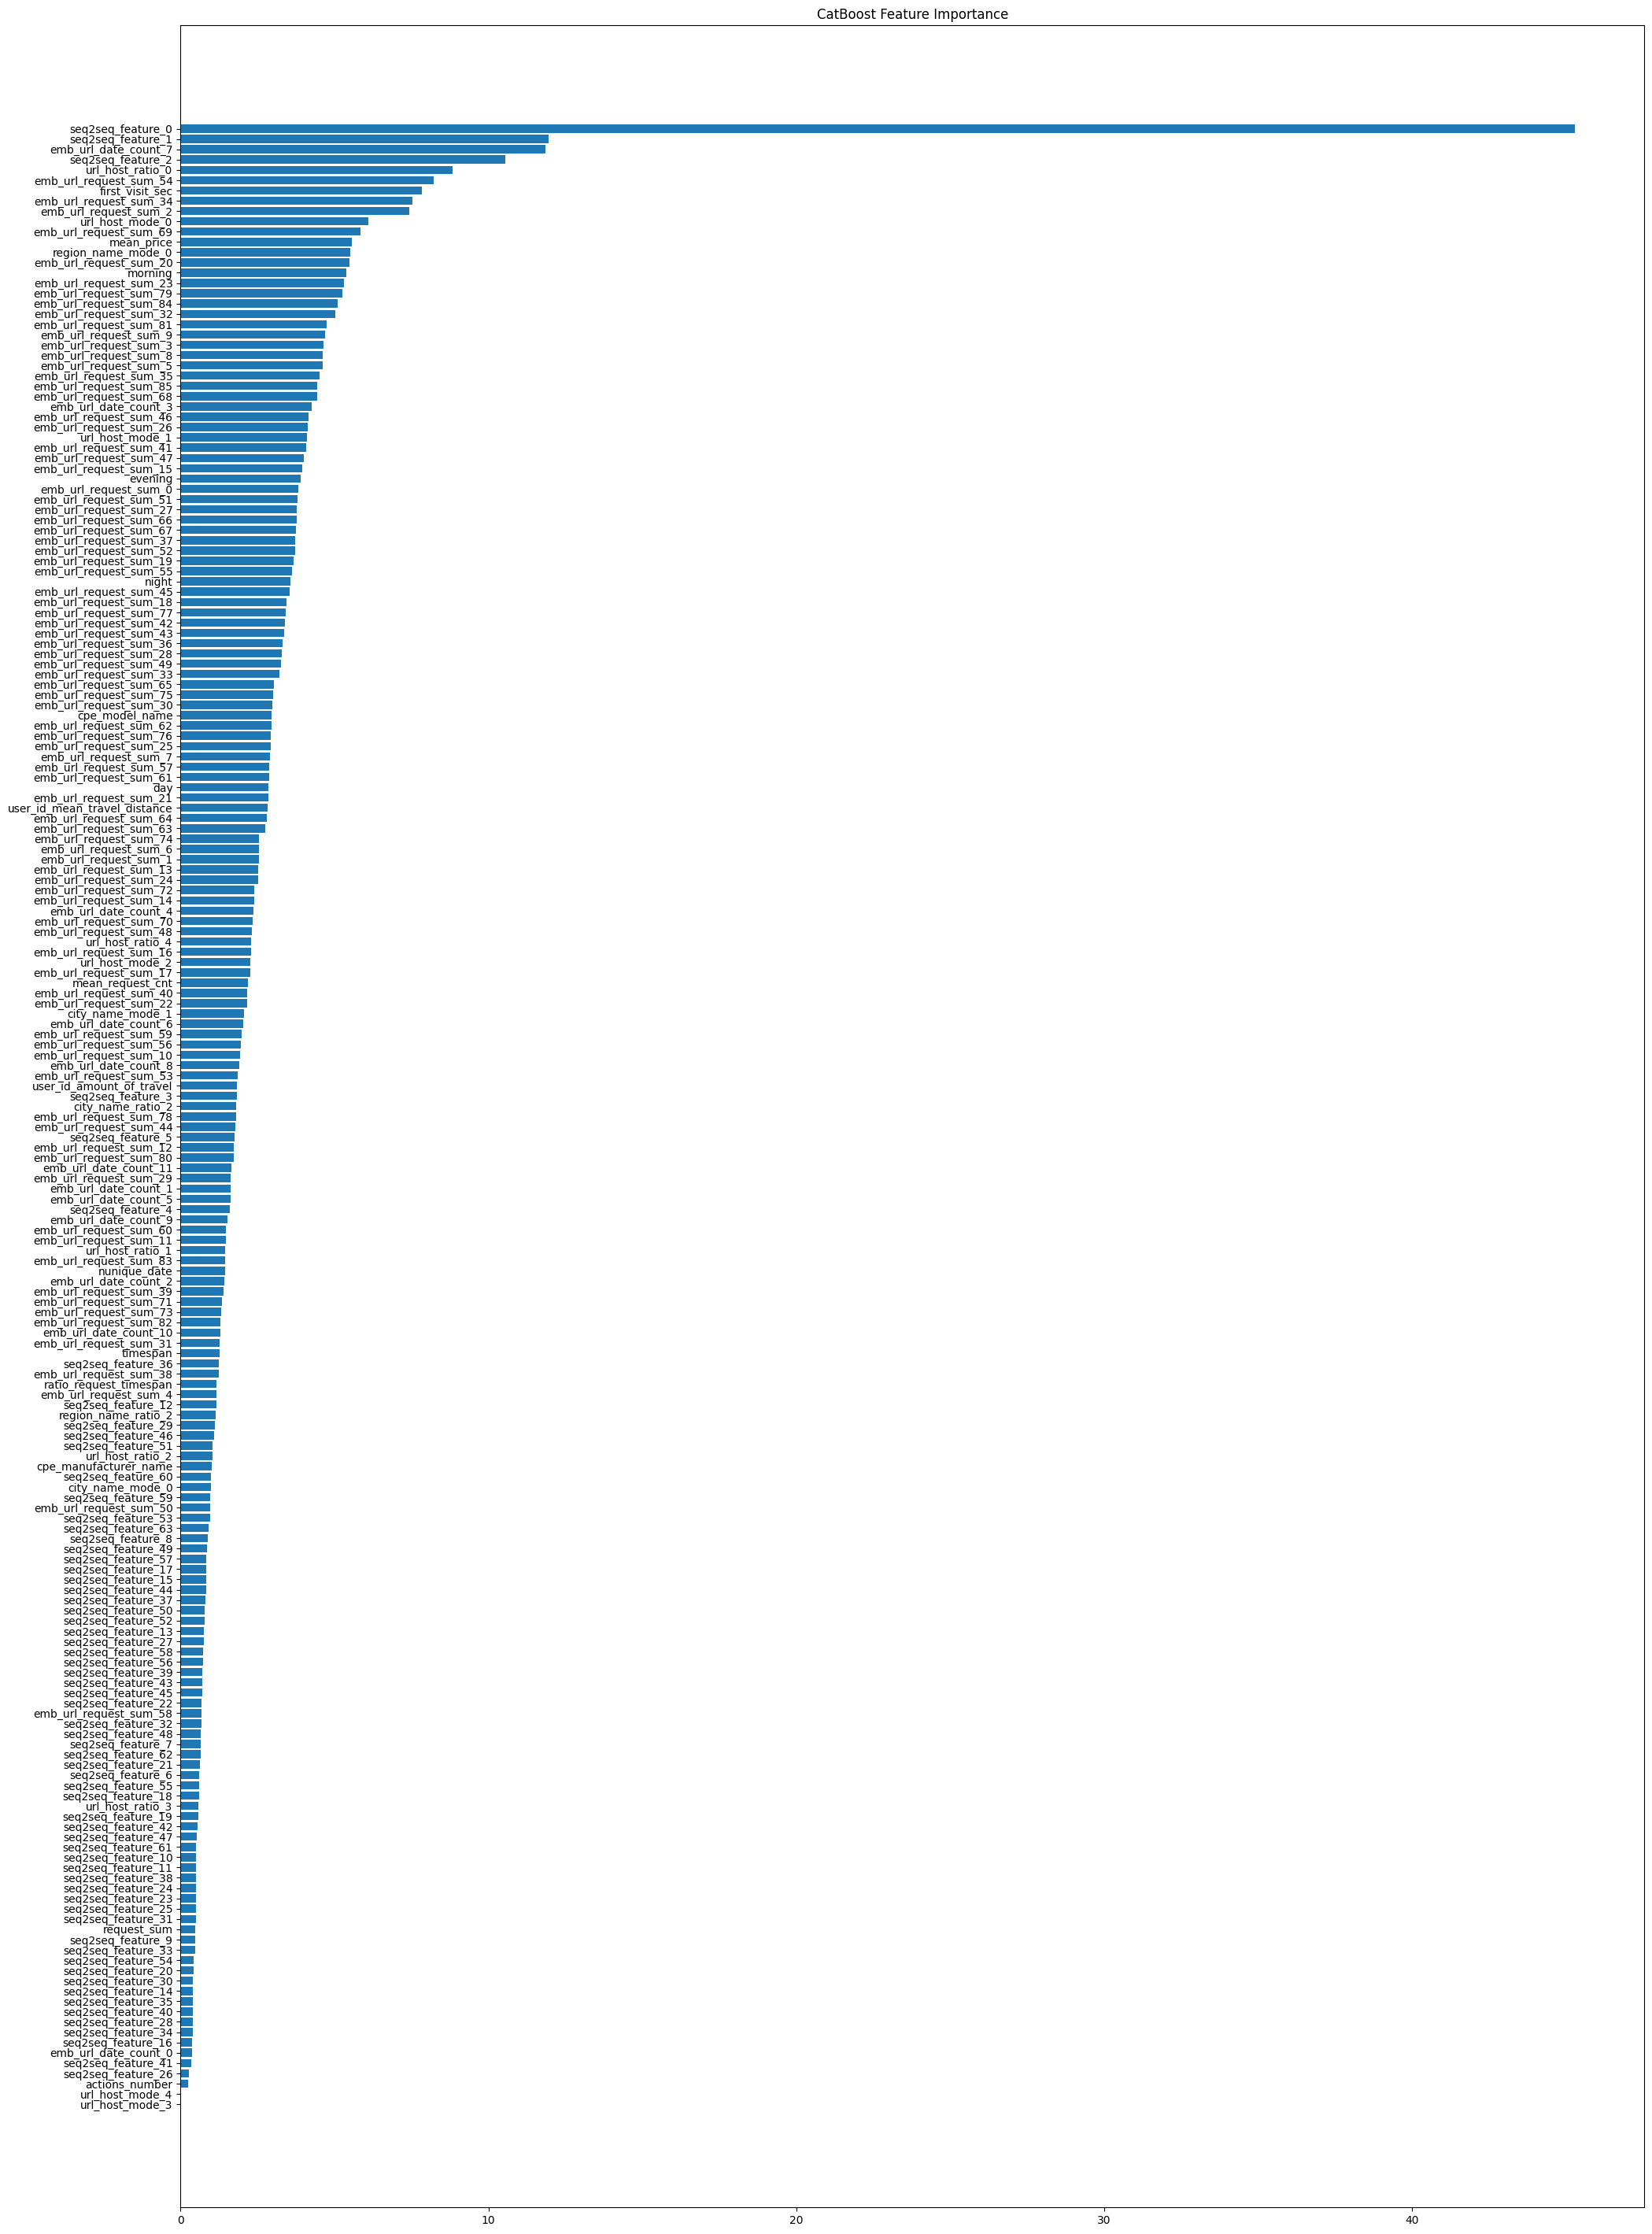

In [16]:
feature_importance = fi["Importance"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 36))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), fi["Feature Id"].to_numpy()[sorted_idx])
plt.title('CatBoost Feature Importance')

In [14]:
age_importances[~age_importances["good"]]

,Feature Id,Importance,std,good
0,cpe_manufacturer_name,0.0,0.0,False
1,cpe_model_name,0.0,0.0,False
2,mean_price,0.0,0.0,False
3,actions_number,0.0,0.0,False
4,nunique_date,0.0,0.0,False
...,...,...,...,...
124,emb_url_date_count_7,0.0,0.0,False
125,emb_url_date_count_8,0.0,0.0,False
126,emb_url_date_count_9,0.0,0.0,False
127,emb_url_date_count_10,0.0,0.0,False


In [15]:
age_kicked = ["cpe_type_cd", "cpe_model_os_type", "region_name_mode_1", "region_name_mode_2", "region_name_ratio_0", "region_name_ratio_1", "city_name_mode_2", "city_name_ratio_0", "city_name_ratio_1", "nunique_region_name", "nunique_city_name"]

Text(0.5, 1.0, 'Permutation Feature Importance')

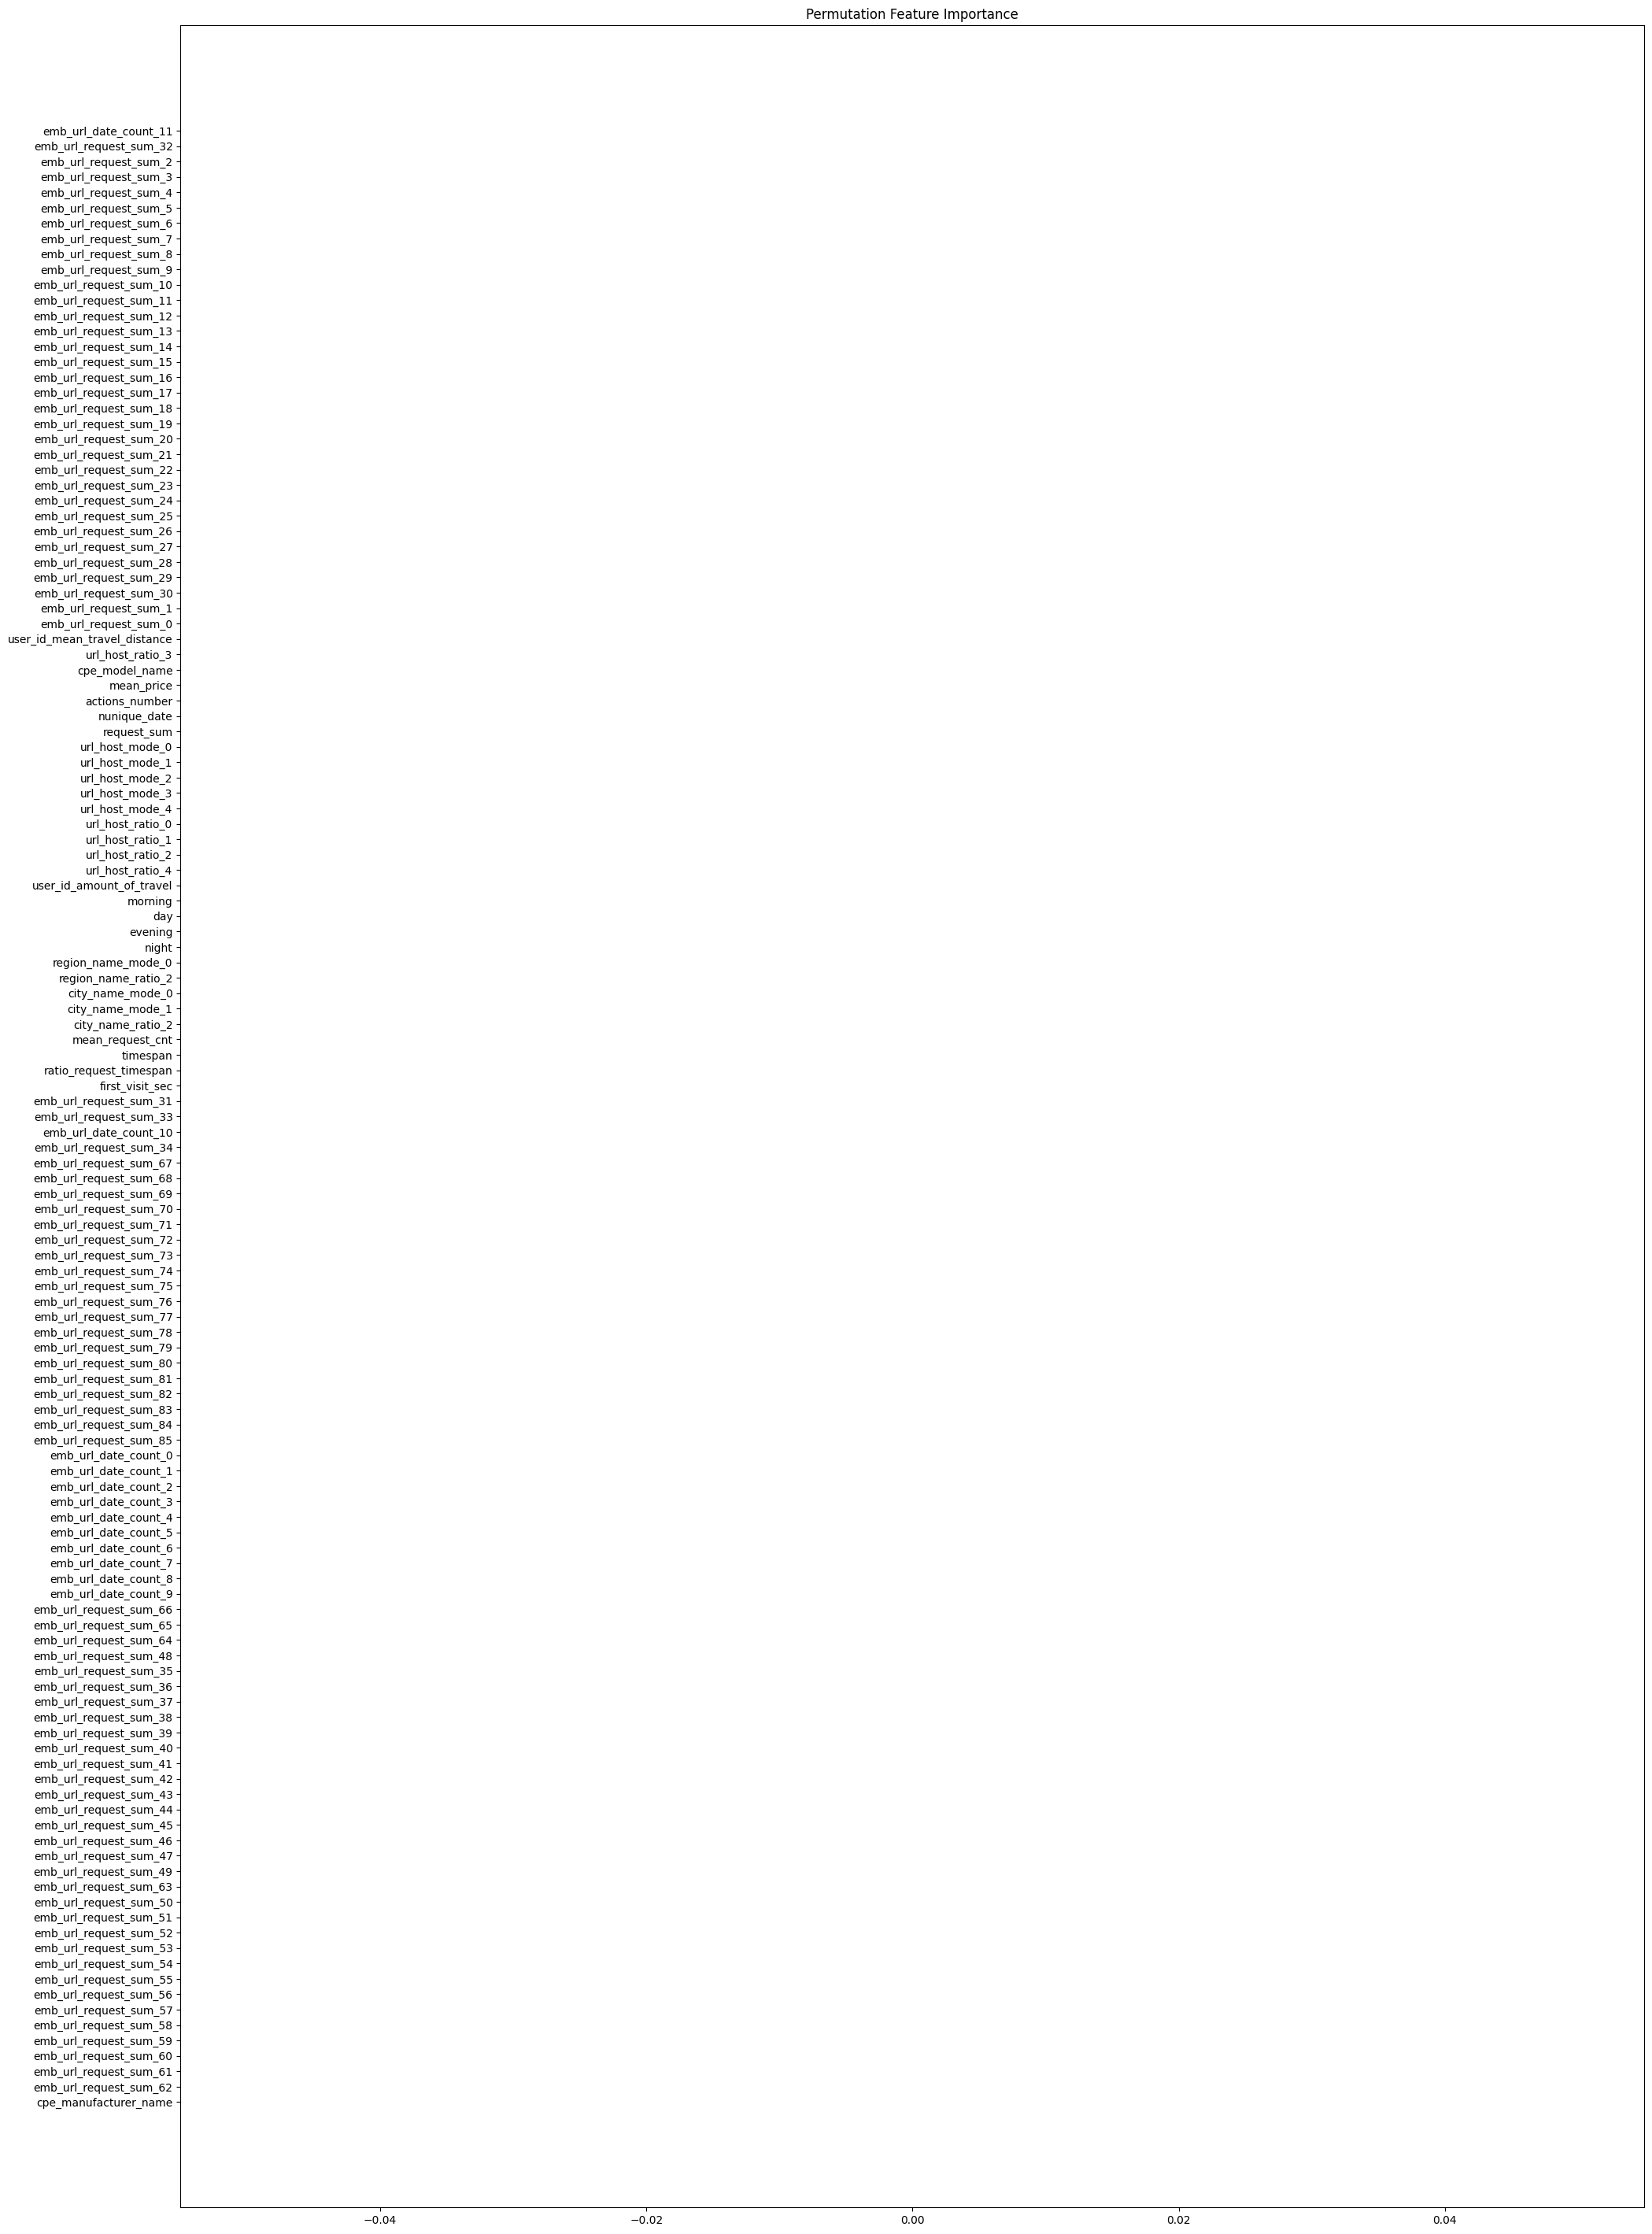

In [16]:
feature_importance = age_importances["Importance"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 36))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), age_importances["Feature Id"].to_numpy()[sorted_idx])
plt.title('Permutation Feature Importance')

#### is_ male classification training

In [16]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import train_test_split

from catboost_modules.metrics import GENDER_METRIC

In [17]:
is_male_kicked = ["cpe_manufacturer_name", "cpe_type_cd", "cpe_model_os_type", "nunique_date", "actions_number", "request_sum", "url_host_mode_4", "url_host_ratio_1", "url_host_ratio_2", "url_host_ratio_3", "url_host_ratio_4"]
df_is_male = userfe.df[userfe.df["is_male"].notna()].drop(columns=["age"] + is_male_kicked)
df_is_male.head()

,cpe_model_name,user_id,is_male,mean_price,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_ratio_0,morning,...,emb_url_date_count_2,emb_url_date_count_3,emb_url_date_count_4,emb_url_date_count_5,emb_url_date_count_6,emb_url_date_count_7,emb_url_date_count_8,emb_url_date_count_9,emb_url_date_count_10,emb_url_date_count_11
2,Galaxy S20+,79395,1.0,74259.000000,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,0.102141,0.211621,...,-0.555467,-0.148673,0.490465,-0.395534,0.551452,-0.641597,0.235146,-1.390079,0.221776,-0.589873
3,Poco X3 Pro,91294,1.0,23876.000000,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,0.145223,0.215287,...,-0.825914,-0.017051,0.723013,0.193677,0.929095,-1.063128,0.400775,-1.512914,0.562912,-0.608336
4,Redmi Note 8 Pro,161323,0.0,20465.000000,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,0.079872,0.562300,...,-0.339168,0.046154,0.644329,0.137939,-0.429767,-1.130276,-0.069693,-1.260576,0.236189,-0.598482
5,Honor 10,304574,1.0,27701.000000,yandex.ru,googleads.g.doubleclick.net,avatars.mds.yandex.net,i.ytimg.com,0.165354,0.196850,...,-0.268395,0.044902,0.489725,0.314726,-0.455802,-0.379812,-0.162521,-0.265319,0.149280,-0.381384
8,Galaxy A40 Dual,16874,0.0,14704.821853,googleads.g.doubleclick.net,yandex.ru,yastatic.net,avatars.mds.yandex.net,0.089074,0.266627,...,-0.630523,0.363971,0.637033,-0.266081,1.148131,-1.468934,0.165384,-1.467837,1.370607,-0.145399


In [18]:
# is_male_cv_embeddings = pandas_reduce_mem_usage(
#     pd.read_parquet("../cv_data/is_male_cv_embeddings.parquet.gzip")
# ).drop(columns=["is_male"])

is_male_cv_logits = pandas_reduce_mem_usage(
    pd.read_parquet("../cv_data/is_male_cv_logits.parquet.gzip")
).drop(columns=["is_male", "target_feature_0"])

is_male_cv_logits.head()

Memory usage of dataframe is 7.06 MB


  0%|          | 0/4 [00:00<?, ?it/s]

Memory usage after optimization is: 7.06 MB
Decreased by 0.0%


,target_feature_1,user_id
0,0.292527,0
1,0.268406,1
2,0.406771,2
3,0.431277,3
4,0.191278,4


In [19]:
df_is_male = df_is_male.merge(
        is_male_cv_logits, on="user_id",how="left"
)
# .merge(
#         is_male_cv_logits, on="user_id",how="left"
# )
df_is_male.isnull().sum().sum()

0

In [20]:
params = {"loss_function": "Logloss",
          "eval_metric": "NormalizedGini",
          "verbose": 100,
          "iterations": 2000,
#           "max_depth": 10,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 200,
          "use_best_model": True,
         }

model_is_male = CatBoostClassifier(**params)

In [21]:
is_male_models, scores, is_male_importances, features = coss_val_score(model=model_is_male, df=df_is_male, target_feature="is_male", metric=GENDER_METRIC, calculate_importance=False)

print(scores)

Learning rate set to 0.033904


Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7165083	best: 0.7165083 (0)	total: 18.1ms	remaining: 36.1s
100:	test: 0.7481712	best: 0.7481712 (100)	total: 1.95s	remaining: 36.7s
200:	test: 0.7512764	best: 0.7512764 (200)	total: 3.89s	remaining: 34.8s
300:	test: 0.7532220	best: 0.7532220 (300)	total: 5.87s	remaining: 33.1s
400:	test: 0.7550916	best: 0.7550916 (400)	total: 7.77s	remaining: 31s
500:	test: 0.7564909	best: 0.7564909 (500)	total: 9.68s	remaining: 29s
600:	test: 0.7574939	best: 0.7574939 (600)	total: 11.6s	remaining: 27s
700:	test: 0.7583739	best: 0.7583739 (700)	total: 13.5s	remaining: 25s
800:	test: 0.7592417	best: 0.7592417 (800)	total: 15.4s	remaining: 23s
900:	test: 0.7599509	best: 0.7599568 (899)	total: 17.3s	remaining: 21.1s
1000:	test: 0.7605725	best: 0.7605725 (1000)	total: 19.2s	remaining: 19.2s
1100:	test: 0.7610583	best: 0.7610583 (1100)	total: 21.1s	remaining: 17.3s
1200:	test: 0.7614801	best: 0.7614801 (1200)	total: 23.1s	remaining: 15.3s
1300:	test: 0.7618704	best: 0.7618704 (1300)	total: 25s	re

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7063739	best: 0.7063739 (0)	total: 20.1ms	remaining: 40.2s
100:	test: 0.7399586	best: 0.7399586 (100)	total: 1.94s	remaining: 36.4s
200:	test: 0.7430781	best: 0.7430781 (200)	total: 3.9s	remaining: 34.9s
300:	test: 0.7453170	best: 0.7453232 (299)	total: 5.91s	remaining: 33.4s
400:	test: 0.7470727	best: 0.7470727 (400)	total: 7.86s	remaining: 31.3s
500:	test: 0.7487068	best: 0.7487068 (500)	total: 9.78s	remaining: 29.3s
600:	test: 0.7496968	best: 0.7496986 (599)	total: 11.7s	remaining: 27.3s
700:	test: 0.7506160	best: 0.7506160 (700)	total: 13.7s	remaining: 25.3s
800:	test: 0.7514388	best: 0.7514388 (800)	total: 15.6s	remaining: 23.3s
900:	test: 0.7520846	best: 0.7520885 (896)	total: 17.5s	remaining: 21.4s
1000:	test: 0.7526732	best: 0.7526732 (1000)	total: 19.5s	remaining: 19.4s
1100:	test: 0.7532165	best: 0.7532165 (1100)	total: 21.4s	remaining: 17.5s
1200:	test: 0.7536939	best: 0.7536939 (1200)	total: 23.3s	remaining: 15.5s
1300:	test: 0.7541524	best: 0.7541524 (1300)	tota

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7161782	best: 0.7161782 (0)	total: 19.7ms	remaining: 39.5s
100:	test: 0.7476962	best: 0.7476962 (100)	total: 1.94s	remaining: 36.5s
200:	test: 0.7510242	best: 0.7510242 (200)	total: 3.91s	remaining: 35s
300:	test: 0.7530900	best: 0.7530900 (300)	total: 5.89s	remaining: 33.3s
400:	test: 0.7547794	best: 0.7547794 (400)	total: 7.83s	remaining: 31.2s
500:	test: 0.7562306	best: 0.7562306 (500)	total: 9.73s	remaining: 29.1s
600:	test: 0.7573882	best: 0.7573882 (600)	total: 11.6s	remaining: 27s
700:	test: 0.7583658	best: 0.7583658 (700)	total: 13.5s	remaining: 25s
800:	test: 0.7592694	best: 0.7592694 (800)	total: 15.3s	remaining: 23s
900:	test: 0.7599446	best: 0.7599446 (900)	total: 17.2s	remaining: 21s
1000:	test: 0.7605233	best: 0.7605233 (1000)	total: 19.1s	remaining: 19.1s
1100:	test: 0.7610182	best: 0.7610182 (1100)	total: 21.1s	remaining: 17.2s
1200:	test: 0.7614761	best: 0.7614761 (1200)	total: 23s	remaining: 15.3s
1300:	test: 0.7618688	best: 0.7618754 (1298)	total: 25s	rema

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7104846	best: 0.7104846 (0)	total: 19.7ms	remaining: 39.5s
100:	test: 0.7443562	best: 0.7443562 (100)	total: 2s	remaining: 37.6s
200:	test: 0.7477091	best: 0.7477091 (200)	total: 4.02s	remaining: 36s
300:	test: 0.7496100	best: 0.7496100 (300)	total: 6.05s	remaining: 34.1s
400:	test: 0.7513073	best: 0.7513073 (400)	total: 8.01s	remaining: 31.9s
500:	test: 0.7527350	best: 0.7527350 (500)	total: 9.96s	remaining: 29.8s
600:	test: 0.7538531	best: 0.7538531 (600)	total: 12s	remaining: 27.8s
700:	test: 0.7546522	best: 0.7546522 (700)	total: 13.9s	remaining: 25.8s
800:	test: 0.7553640	best: 0.7553640 (800)	total: 15.8s	remaining: 23.7s
900:	test: 0.7560533	best: 0.7560533 (900)	total: 17.8s	remaining: 21.7s
1000:	test: 0.7565488	best: 0.7565488 (1000)	total: 19.7s	remaining: 19.7s
1100:	test: 0.7571470	best: 0.7571501 (1099)	total: 21.7s	remaining: 17.7s
1200:	test: 0.7575238	best: 0.7575238 (1200)	total: 23.6s	remaining: 15.7s
1300:	test: 0.7578869	best: 0.7578869 (1300)	total: 25.

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7152281	best: 0.7152281 (0)	total: 18.2ms	remaining: 36.4s
100:	test: 0.7463880	best: 0.7463880 (100)	total: 1.94s	remaining: 36.5s
200:	test: 0.7496048	best: 0.7496048 (200)	total: 3.91s	remaining: 35s
300:	test: 0.7514973	best: 0.7514973 (300)	total: 5.9s	remaining: 33.3s
400:	test: 0.7532459	best: 0.7532459 (400)	total: 7.84s	remaining: 31.3s
500:	test: 0.7545570	best: 0.7545570 (500)	total: 9.76s	remaining: 29.2s
600:	test: 0.7557385	best: 0.7557388 (599)	total: 11.7s	remaining: 27.2s
700:	test: 0.7565753	best: 0.7565753 (700)	total: 13.6s	remaining: 25.2s
800:	test: 0.7572506	best: 0.7572506 (800)	total: 15.5s	remaining: 23.2s
900:	test: 0.7579061	best: 0.7579061 (900)	total: 17.5s	remaining: 21.3s
1000:	test: 0.7584455	best: 0.7584455 (1000)	total: 19.5s	remaining: 19.4s
1100:	test: 0.7589686	best: 0.7589715 (1099)	total: 21.4s	remaining: 17.5s
1200:	test: 0.7594395	best: 0.7594428 (1199)	total: 23.4s	remaining: 15.6s
1300:	test: 0.7598358	best: 0.7598374 (1298)	total:

0.7611993345854822 - seq2eq logits

In [24]:
for i, model in enumerate(is_male_models):
    model.save_model(f"../catboost_models/is_male_v2/cb_is_male_v2_{i}")

In [22]:
fi = pd.DataFrame(data={
    "Feature Id": is_male_models[0].get_feature_importance(prettified=True).sort_values("Feature Id")["Feature Id"],
    "Importamce": sum([model.get_feature_importance(prettified=True).sort_values("Feature Id")["Importances"].to_numpy().flatten() for model in is_male_models])
})
fi

,Feature Id,Importamce
86,city_name_mode_0,1.428252
80,city_name_mode_1,1.616416
126,city_name_mode_2,0.597690
109,city_name_ratio_0,0.937955
76,city_name_ratio_1,1.763636
...,...,...
57,url_host_mode_2,2.198857
67,url_host_mode_3,1.973144
23,url_host_ratio_0,3.843949
11,user_id_amount_of_travel,4.772249


Text(0.5, 1.0, 'Feature Importance')

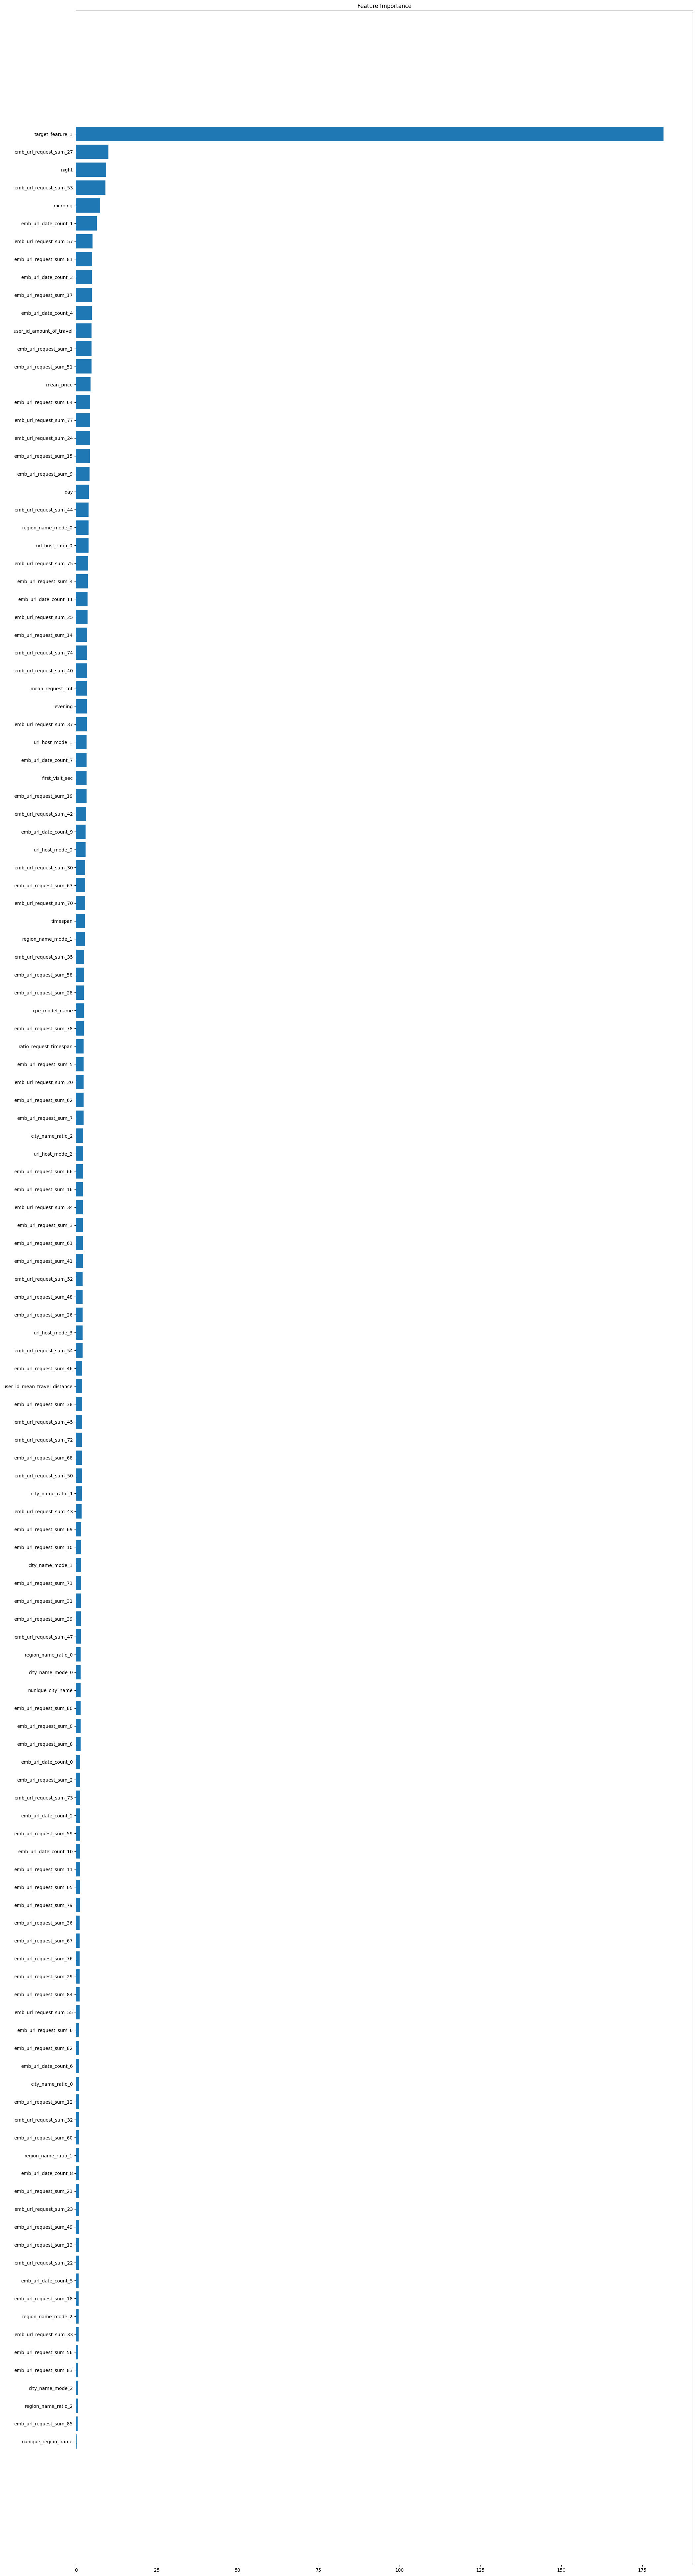

In [23]:
feature_importance = fi["Importamce"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 100))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), fi["Feature Id"].to_numpy()[sorted_idx])
plt.title('Feature Importance')

In [64]:
is_male_importances["good"].sum(), is_male_importances["good"].sum() / is_male_importances.shape[0]

(58, 0.4142857142857143)

In [68]:
is_male_importances[~is_male_importances["good"]].head(90)

,Feature Id,Importance,std,good
0,cpe_manufacturer_name,0.000112,0.000234,False
2,cpe_type_cd,-0.000002,0.000013,False
3,cpe_model_os_type,-0.000007,0.000050,False
4,mean_price,0.000204,0.000291,False
5,actions_number,0.000048,0.000212,False
...,...,...,...,...
125,emb_url_request_sum_83,0.000017,0.000141,False
126,emb_url_request_sum_84,0.000582,0.000380,False
127,emb_url_request_sum_85,0.000079,0.000173,False
134,emb_url_date_count_6,0.001074,0.000541,False


Text(0.5, 1.0, 'Permutation Feature Importance')

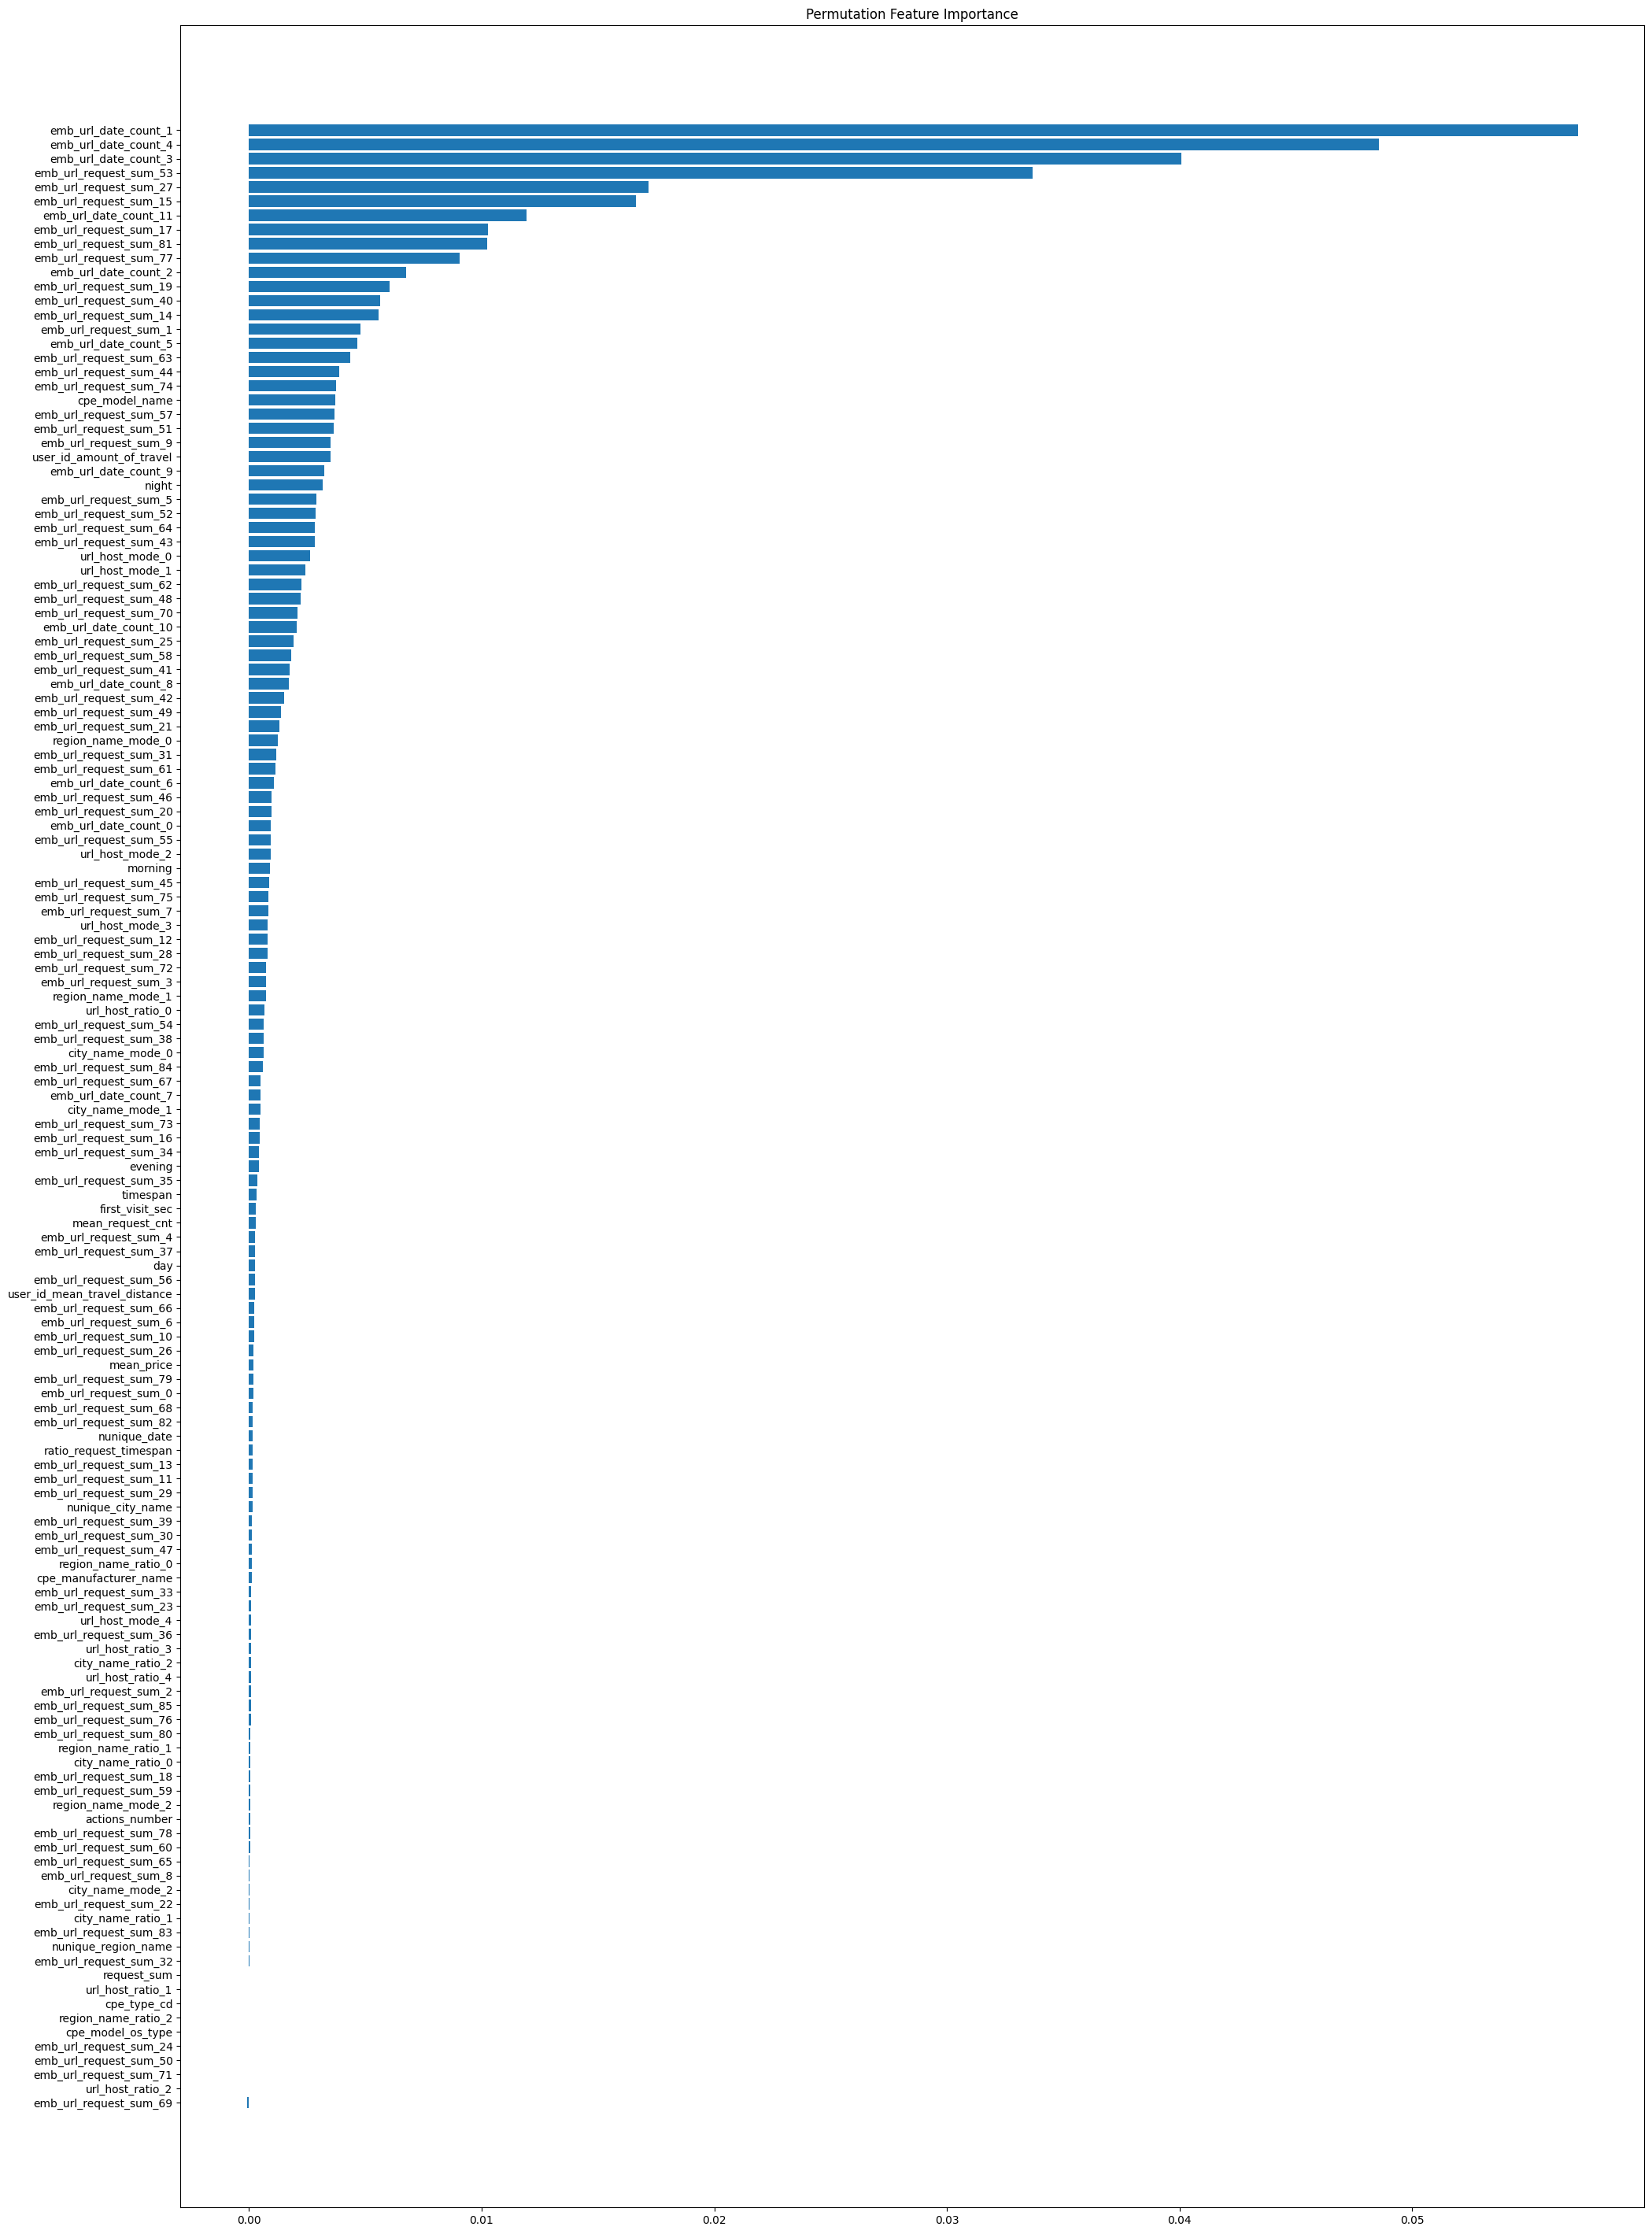

In [66]:
feature_importance = is_male_importances["Importance"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 36))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), is_male_importances["Feature Id"].to_numpy()[sorted_idx])
plt.title('Permutation Feature Importance')

# Predict

In [26]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from tqdm.auto import tqdm

In [27]:
FE_DATA = "../fe_data/"
userfe = UserFE()
userfe.load(path=f"{FE_DATA}/USER_FE.parquet.gzip")
userfe.df

Memory usage of dataframe is 282.01 MB


  0%|          | 0/143 [00:00<?, ?it/s]

Memory usage after optimization is: 282.01 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,emb_url_date_count_2,emb_url_date_count_3,emb_url_date_count_4,emb_url_date_count_5,emb_url_date_count_6,emb_url_date_count_7,emb_url_date_count_8,emb_url_date_count_9,emb_url_date_count_10,emb_url_date_count_11
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,-0.487459,-0.451297,0.205221,0.365753,-0.038074,-0.371062,-0.347951,-1.124802,1.116378,-0.605543
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,-0.476611,0.130673,0.132837,0.025192,-0.379870,-0.384682,-0.486816,-0.743641,0.278062,-0.606177
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,-0.555467,-0.148673,0.490465,-0.395534,0.551452,-0.641597,0.235146,-1.390079,0.221776,-0.589873
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,-0.825914,-0.017051,0.723013,0.193677,0.929095,-1.063128,0.400775,-1.512914,0.562912,-0.608336
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,-0.339168,0.046154,0.644329,0.137939,-0.429767,-1.130276,-0.069693,-1.260576,0.236189,-0.598482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415312,Apple,iPhone X,smartphone,iOS,375972,48.0,0.0,56357.0,690,61,...,-0.367244,-0.221943,-0.024665,0.066285,-0.320592,-0.569684,-0.632674,-1.020382,0.607768,-0.268611
415313,Apple,iPhone 7,smartphone,iOS,160996,NaN,NaN,26154.0,460,23,...,-0.388560,-0.080856,0.157780,0.331962,-0.134558,-0.337920,-0.589342,-0.975730,0.333884,0.006961
415314,Huawei,P Smart Z,smartphone,Android,5505,26.0,1.0,15490.0,96,11,...,-0.312762,-0.006308,0.661723,0.378763,-0.299067,-0.438742,-0.275950,-0.060483,0.209070,-0.446256
415315,Apple,iPhone SE 2020,smartphone,iOS,260127,NaN,NaN,40612.0,860,27,...,-0.214815,0.144838,0.386581,0.309508,-0.513405,-0.109134,-0.485071,-1.433589,1.055682,-0.613989


In [28]:
LOCAL_DATA = "../data"

needed_ids = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/submit_2.pqt')
) 
needed_ids.head()

Memory usage of dataframe is 2.21 MB


  0%|          | 0/1 [00:00<?, ?it/s]

Memory usage after optimization is: 1.66 MB
Decreased by 25.0%


,user_id
221301,221301
31271,31271
211594,211594
253119,253119
192578,192578


In [29]:
test = needed_ids.merge(userfe.df.drop(columns=["age", "is_male"]), on="user_id", how="left")
test.head()

,user_id,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,mean_price,actions_number,nunique_date,request_sum,url_host_mode_0,...,emb_url_date_count_2,emb_url_date_count_3,emb_url_date_count_4,emb_url_date_count_5,emb_url_date_count_6,emb_url_date_count_7,emb_url_date_count_8,emb_url_date_count_9,emb_url_date_count_10,emb_url_date_count_11
0,221301,Apple,iPhone SE,smartphone,iOS,14381.0,564,19,1192,instagram.com,...,-0.477768,-0.304121,0.281711,0.437949,-0.379156,-0.277914,-0.473263,-0.902318,0.662917,-0.497679
1,31271,Samsung,Galaxy A30 Dual,smartphone,Android,12636.0,4,1,10,yandex.ru,...,-0.077670,0.001416,0.290030,0.140780,-0.076636,-0.105728,-0.127635,0.096999,0.075125,-0.063195
2,211594,Xiaomi,Poco X3 Pro,smartphone,Android,23876.0,4,2,7,unblock.mts.ru,...,-0.078477,0.027607,0.186699,-0.009173,-0.037037,-0.017283,-0.128097,0.102028,0.084676,-0.047032
3,253119,Xiaomi,Redmi 9,smartphone,Android,13133.0,14,2,16,i.ytimg.com,...,-0.162264,0.003588,0.537526,0.285017,-0.186246,-0.246277,-0.273464,0.098354,0.160195,-0.181369
4,192578,Apple,iPhone 7,smartphone,iOS,42009.0,143,6,216,apple.com,...,-0.315334,-0.048776,0.668127,0.383950,-0.368453,-0.325255,-0.687155,-0.386749,0.482435,-0.204027


In [31]:
is_male_embeddings_df = pd.read_parquet(f"../test_is_male_logits.parquet.gzip").drop(columns=["target_feature_0"])
age_embeddings_df = pd.read_parquet(f"../test_age_logits.parquet.gzip")

is_male_embeddings_df.head()

,target_feature_1,user_id
0,0.450140,6
1,0.671860,7
2,0.456391,9
3,0.286317,10
4,0.742313,11


In [32]:
age_embeddings_df.head()

,target_feature_0,target_feature_1,target_feature_2,target_feature_3,target_feature_4,target_feature_5,user_id
0,0.033956,0.136560,0.266697,0.280620,0.183845,0.098323,6
1,0.015066,0.072248,0.198331,0.340407,0.269000,0.104947,7
2,0.008553,0.051414,0.172918,0.328595,0.292672,0.145848,9
3,0.013551,0.097607,0.264784,0.341348,0.201563,0.081146,10
4,0.033808,0.141548,0.273851,0.282155,0.176864,0.091774,11


In [33]:
age_test = test.merge(age_embeddings_df, on="user_id", how="left")
is_male_test = test.merge(is_male_embeddings_df, on="user_id", how="left")

age_test.isnull().sum().sum(), is_male_test.isnull().sum().sum()

(0, 0)

In [34]:
(age_test["user_id"] == is_male_test["user_id"]).sum() / is_male_test.shape[0]

1.0

In [35]:
age_X_test = age_test.drop(columns=["user_id"])
is_male_X_test = is_male_test.drop(columns=["user_id"])

In [36]:
def cross_val_predict(model_folder, df, drop_columns=None):
    if drop_columns: 
        df = df.drop(columns=drop_columns)
        print("YEAAAAAAAAAAH BITCH")
        
    test_pool = Pool(df, cat_features=np.where(df.dtypes == object)[0])
    
    model_names = os.listdir(model_folder)
    
    preds = []
    
    for model_name in tqdm(model_names):
        model = CatBoostClassifier().load_model(f"{model_folder}/{model_name}")
        pred = model.predict_proba(test_pool)
        
        preds.append(pred)
    
    return sum(preds) / len(preds)

In [37]:
age_preds = cross_val_predict("../catboost_models/age_v2", age_X_test, drop_columns=age_kicked).argmax(axis=1) + 1
needed_ids["age"] = age_preds

age_preds

YEAAAAAAAAAAH BITCH


  0%|          | 0/5 [00:00<?, ?it/s]

array([2, 3, 2, ..., 3, 2, 3])

In [38]:
is_male_preds = cross_val_predict("../catboost_models/is_male_v2", is_male_X_test, drop_columns=is_male_kicked)[:, 1]
needed_ids["is_male"] = is_male_preds

is_male_preds

YEAAAAAAAAAAH BITCH


  0%|          | 0/5 [00:00<?, ?it/s]

array([0.84585252, 0.52471032, 0.51344764, ..., 0.5082907 , 0.62324884,
       0.45342701])

In [39]:
needed_ids

,user_id,age,is_male
221301,221301,2,0.845853
31271,31271,3,0.524710
211594,211594,2,0.513448
253119,253119,2,0.647268
192578,192578,2,0.828737
...,...,...,...
145307,415284,2,0.450852
145308,415285,2,0.542198
145309,415286,3,0.508291
145312,415306,2,0.623249


In [43]:
needed_ids.to_csv("catboost_with_seq2seq_v3.csv", index=False)